   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 839.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.6 MB/s eta 0:00:00
Mounted at /content/drive
Epoch 1/10 - Train Acc: 49.86% - Val Acc: 53.89%
Class-wise Validation Accuracy:
  Class 1 star: 69.18%
  Class 2 star: 46.98%
  Class 3 star: 39.97%
  Class 4 star: 47.85%
  C

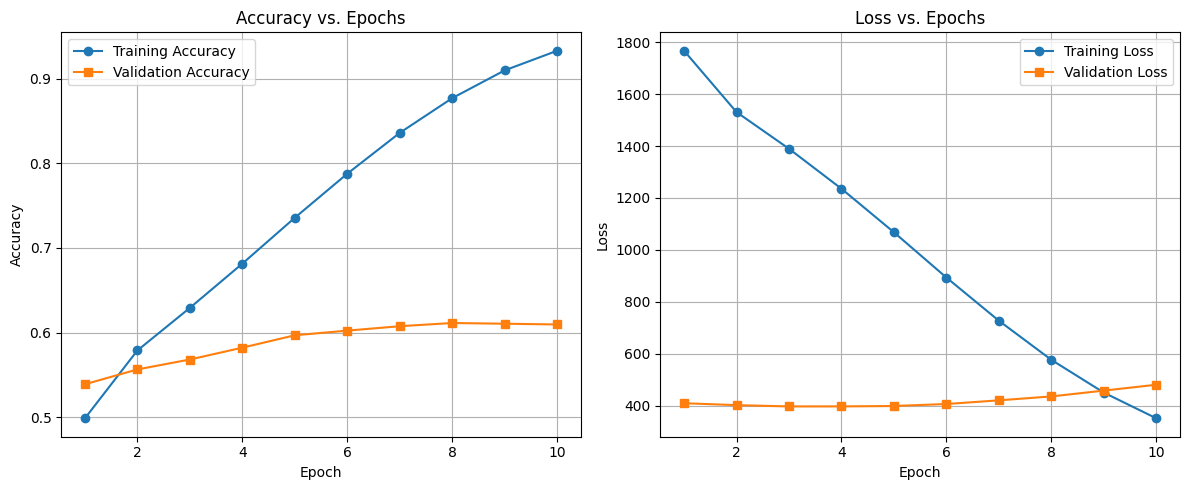

In [ ]:
# Install packages
!pip install -q torch scikit-learn pandas matplotlib

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from collections import defaultdict  # for tracking class-wise accuracy

# Load Data
train_path = '/content/drive/MyDrive/FOOD_REVIEW_DATA/train.csv'
test_path = '/content/drive/MyDrive/FOOD_REVIEW_DATA/test.csv'
train_df = pd.read_csv(train_path, header=0)
test_df = pd.read_csv(test_path, header=0)

# Convert original scores (1–5) to labels (0–4)
train_df["Label"] = train_df["Score"] - 1
test_df["Label"] = test_df["Score"] - 1

# TF-IDF converts review text to numeric features
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X = vectorizer.fit_transform(train_df["Text"]).toarray()
y = train_df["Label"].values

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create custom PyTorch Dataset
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Wrap the data in PyTorch DataLoaders
train_dataset = ReviewDataset(X_train, y_train)
val_dataset = ReviewDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Define a simple MLP model with 1 hidden layer
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.model(x)

# Set model, loss, and optimizer
input_dim = X.shape[1]
hidden_dim = 256
output_dim = 5

model = MLP(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to track metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_train, total_train = 0, 0

    # Training step
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct_train += (preds == batch_y).sum().item()
        total_train += batch_y.size(0)

    train_losses.append(total_loss)
    train_accuracies.append(correct_train / total_train)

    # Validation step with class-wise accuracy
    model.eval()
    correct_val, total_val, val_loss = 0, 0, 0
    class_correct = defaultdict(int)   # tracks correct predictions per class
    class_total = defaultdict(int)     # tracks total samples per class

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_val += (preds == batch_y).sum().item()
            total_val += batch_y.size(0)

            # Count correct predictions for each class
            for label, pred in zip(batch_y, preds):
                class_total[int(label)] += 1
                if label == pred:
                    class_correct[int(label)] += 1

    val_losses.append(val_loss)
    val_accuracies.append(correct_val / total_val)

    # Print results for this epoch
    print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_accuracies[-1]*100:.2f}% - Val Acc: {val_accuracies[-1]*100:.2f}%")
    print("Class-wise Validation Accuracy:")
    for i in range(5):
        acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"  Class {i+1} star: {acc:.2f}%")

# Plot training, validation accuracy/loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Predict on Test Set
X_test = vectorizer.transform(test_df["Text"]).toarray()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    preds = torch.argmax(outputs, dim=1)

# Convert 0–4 predictions back to 1–5 stars
test_df["Predicted_Score"] = preds.numpy() + 1
test_df.to_csv("mlp_predictions.csv", index=False)
print("Predictions saved to mlp_predictions.csv")
